In [1]:
#!pip uninstall -y scipy
#!pip install scipy

In [2]:
import scipy
scipy.__version__

'1.0.1'

In [3]:
#!pip uninstall -y scikit-surprise

In [4]:
#!pip install scikit-surprise
#!pip install wordcloud

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from zope.interface import Interface,implementer
from collections import Counter
from collections import defaultdict
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error
import re
plt.figure(figsize=(7,7))


In [6]:
def popular_set(data):
    popmovies_counter = Counter([count[1] for count in data])
    popmovies_dataset = [count for count in data if popmovies_counter[count[1]] > 2]
    return popmovies_dataset
    #return list(filter(lambda x:x[2] > 2.0, data))

In [7]:
def unpopular_set(data):
    #return list(filter(lambda x:x[2] <= 2.0, data))
    popmovies_counter = Counter([count[1] for count in data])
    popmovies_dataset = [count for count in data if popmovies_counter[count[1]] <= 2]
    return popmovies_dataset

In [8]:
def highvar1(data):
    
    ranking_dict = defaultdict(list)
    for i, j in zip(data[1],data[2]):
        ranking_dict[i].append(j)
    
    var = []
    for l in data:
        if len(ranking_dict[l[1]]) >=5 and np.var(ranking_dict[l[1]]) >= 2.0:
            var.append(l)
    
    return var
    

In [9]:
def highvar(data):
    movielist = defaultdict(list)
    for count in data:
#        movielist[val[1]].append(val[2])
         movielist[count[1]].append(count[2])
    highvar_movies = [count for count in data if len(movielist[count[1]]) >= 5 and np.var(movielist[count[1]]) >= 2]
    return highvar_movies

In [10]:
class Plot(Interface):
    def draw():
        pass

@implementer(Plot)
class Hist:

    def __init__(self, bins, title, ticks, xlabel, ylabel):
        
        self.bins = bins
        self.title = title
        self.ticks = ticks
        self.xlabel = xlabel
        self.ylabel = ylabel
        
    def draw(self, data):
        %matplotlib inline

        plt.hist(data,bins = self.bins,edgecolor="b",rwidth=0.8)
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.grid('on')

        plt.xticks(self.ticks)
        plt.show()
        
    

In [11]:
@implementer(Plot)
class Bar:
    def __init__(self, title, xlabel, ylabel, ticks = None,):
        
        self.title = title
        self.ticks = ticks
        self.xlabel = xlabel
        self.ylabel = ylabel
        
    def draw(self, data):
        %matplotlib inline
        plt.bar(data['X'],data['height'])
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.grid('on')

        plt.xticks([],[])
        plt.show()
    

In [12]:
@implementer(Plot)
class errPlot:
    def __init__(self, title, xlabel, ylabel, ticks):
        self.title = title
        self.ticks = ticks
        self.xlabel = xlabel
        self.ylabel = ylabel
        
    
    def draw(self, data):
        %matplotlib inline
        plt.plot(data['r'], data['err'], color = data['color'])
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.grid('on')
        plt.xticks(self.ticks,rotation="vertical",color='blue')
        plt.show()



In [13]:
class errorMeas:
    def __init__(self):
        self.meas = []
        


In [14]:
class Algo(Interface):
    
    def runAlgo():
        pass

In [15]:
@implementer(Algo)
class KNN:
    def __init__(self, splits, cv):
        self.r = range(2, 102, 2)
        self.kf = KFold(n_splits=splits)
        self.reader = Reader(rating_scale=(0.5, 5))
        self.cv = cv

    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        rmse = errorMeas()
        mae = errorMeas()
        
        for k in self.r:
            pearson = KNNWithMeans(k=k, sim_options = {'name':'pearson'}) 
            results = cross_validate(pearson, data, measures=['RMSE', 'MAE'], cv=self.cv, verbose=False)
            rmse.meas.append(np.mean(results['test_rmse']))
            mae.meas.append(np.mean(results['test_mae']))
        return rmse, mae
        

In [44]:
@implementer(Algo)
class KnnWithTrainTestSplit:
    def __init__(self, split, k, threshold = None):
        
        self.reader = Reader(rating_scale=(0.5, 5))
        self.split = split
        self.k = k
        self.threshold = threshold
        
    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        train, test = train_test_split(data, test_size=self.split, random_state=0)

        pearson = KNNWithMeans(k=self.k, sim_options = {'name':'pearson'}) 
        pearson.fit(train)
        predict = pearson.test(test)
        
        self.est = np.array([i.est for i in predict])
        self.act = np.array([i.r_ui for i in predict])
        
    def plotRoc(self):
        for t in self.threshold:
            y_score = self.est
            y_true = (self.act >= t)

            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            plt.grid('true', linestyle='-', linewidth=1)
            plt.plot(fpr, tpr, lw=2, label='Threshold = %0.1f, AUC = %0.4f' % (t,roc_auc),color='red')
            plt.xlabel('FPR',fontsize=20)
            plt.ylabel('TPR',fontsize=20)
            plt.legend(loc ='best',fontsize=12)
            plt.title('Q15: ROC for threshold = %0.1f' %t)
            plt.xticks(fontsize=12,color='blue')
            plt.yticks(fontsize=12,color='blue')
            plt.show()
  

In [17]:
@implementer(Algo)
class kFoldKNN:
    def __init__(self, splits, cv, trim_algo):
        self.r = range(2, 102, 2)
        self.kf = KFold(n_splits=splits)
        self.reader = Reader(rating_scale=(0.5, 5))
        self.cv = cv
        self.trim_algo = trim_algo
        
    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        rmse = errorMeas()
        #mae = errorMeas()
        
        for k in self.r:
            pearson = KNNWithMeans(k=k, sim_options = {'name':'pearson'}) 
            i_rmse = []
            for trainset, testset in self.kf.split(data):
                pearson.fit(trainset)
                predict = pearson.test(self.trim_algo(testset))

                i_rmse.append(accuracy.rmse(predict, verbose = False))
            rmse.meas.append(np.mean(i_rmse))
        return rmse

In [18]:
@implementer(Algo)
class kFoldNMF:
    def __init__(self, cv):
        self.r = range(2, 52, 2)
        self.reader = Reader(rating_scale=(0.5, 5))
        self.cv = cv

    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        rmse = errorMeas()
        mae = errorMeas()
        
        for k in self.r:
            nmf = NMF(n_factors=k) 
            results = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=self.cv, verbose=False)
            rmse.meas.append(np.mean(results['test_rmse']))
            mae.meas.append(np.mean(results['test_mae']))
        return rmse, mae

In [19]:
@implementer(Algo)
class kFoldNMFTrimmed:
    def __init__(self, splits, cv, trim_algo):
        self.r = range(2, 52, 2)
        self.kf = KFold(n_splits=splits)
        self.reader = Reader(rating_scale=(0.5, 5))
        self.cv = cv
        self.trim_algo = trim_algo
        
    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        rmse = errorMeas()
        
        for k in self.r:
            nmf = NMF(n_factors=k) 
            i_rmse = []
            for trainset, testset in self.kf.split(data):
                nmf.fit(trainset)
                predict = nmf.test(self.trim_algo(testset))
                if predict :
                    i_rmse.append(accuracy.rmse(predict, verbose = False))
            rmse.meas.append(np.mean(i_rmse))
        return rmse

In [20]:
@implementer(Algo)
class NMFWithTrainTestSplit:
    def __init__(self, split, k, threshold = None):
        
        self.reader = Reader(rating_scale=(0.5, 5))
        self.split = split
        self.k = k
        self.threshold = threshold

    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        train, test = train_test_split(data, test_size=self.split, random_state=0)

        nmf = NMF(n_factors=self.k) 
        nmf.fit(train)
        predict = nmf.test(test)
        
        self.est = np.array([i.est for i in predict])
        self.act = np.array([i.r_ui for i in predict])
        self.u = nmf.pu
        self.v = nmf.qi
    def plotRoc(self):
        
        for t in self.threshold:
            y_score = self.est
            y_true = (self.act >= t)
            
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            plt.grid('true', linestyle='-', linewidth=1)
            plt.plot(fpr, tpr, lw=2, label='Threshold = %0.1f, AUC = %0.4f' % (t,roc_auc),color='red')
            plt.xlabel('FPR',fontsize=20)
            plt.ylabel('TPR',fontsize=20)
            plt.legend(loc ='best',fontsize=12)
            plt.title('Q22: ROC for threshold = %0.1f' %t)
            plt.xticks(fontsize=12,color='blue')
            plt.yticks(fontsize=12,color='blue')
            plt.show()
        
    def getTopMovies(self):
        movies = pd.read_csv('ml-latest-small/movies.csv')
        for mov in range(self.v.shape[1]):
            print('\nTop Movie - ', mov)
            mov_name = self.v[: ,mov]
            top10_movies = mov_name.argsort()[-10:][::-1]
            top10_movies_genres = [(movies.genres[i]) for i in top10_movies]
            #  print (top10_movies)
            print(top10_movies_genres)


    
  

In [21]:
@implementer(Algo)
class kFoldSVD:
    def __init__(self, cv):
        self.r = range(2, 52, 2)
        self.reader = Reader(rating_scale=(0.5, 5))
        self.cv = cv

    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        rmse = errorMeas()
        mae = errorMeas()
        
        for k in self.r:
            svd = SVD(n_factors=k) 
            results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=self.cv, verbose=False)
            rmse.meas.append(np.mean(results['test_rmse']))
            mae.meas.append(np.mean(results['test_mae']))
        return rmse, mae

In [22]:
@implementer(Algo)
class kFoldSVDTrimmed:
    def __init__(self, splits, cv, trim_algo):
        self.r = range(2, 52, 2)
        self.kf = KFold(n_splits=splits)
        self.reader = Reader(rating_scale=(0.5, 5))
        self.cv = cv
        self.trim_algo = trim_algo
        
    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        rmse = errorMeas()
        
        for k in self.r:
            svd = SVD(n_factors=k) 
            i_rmse = []
            for trainset, testset in self.kf.split(data):
                svd.fit(trainset)
                predict = svd.test(self.trim_algo(testset))
                if predict :
                    i_rmse.append(accuracy.rmse(predict, verbose = False))
            rmse.meas.append(np.mean(i_rmse))
        return rmse

In [23]:
@implementer(Algo)
class SVDWithTrainTestSplit:
    def __init__(self, split, k, threshold = None):
        
        self.reader = Reader(rating_scale=(0.5, 5))
        self.split = split
        self.k = k
        self.threshold = threshold

    def runAlgo(self, df):
        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        train, test = train_test_split(data, test_size=self.split, random_state=0)

        svd = SVD(n_factors=self.k) 
        svd.fit(train)
        predict = svd.test(test)
        
        self.est = np.array([i.est for i in predict])
        self.act = np.array([i.r_ui for i in predict])
        
    def plotRoc(self):
        
        for t in self.threshold:
            y_score = self.est
            y_true = (self.act >= t)
            
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            plt.grid('true', linestyle='-', linewidth=1)
            plt.plot(fpr, tpr, lw=2, label='Threshold = %0.1f, AUC = %0.4f' % (t,roc_auc),color='red')
            plt.xlabel('FPR',fontsize=20)
            plt.ylabel('TPR',fontsize=20)
            plt.legend(loc ='best',fontsize=12)
            plt.title('Q29: ROC for threshold = %0.1f' %t)
            plt.xticks(fontsize=12,color='blue')
            plt.yticks(fontsize=12,color='blue')
            plt.show()
  

In [24]:
@implementer(Algo)
class kFoldNF:
    def __init__(self, splits, trim_algo = None):
        self.reader = Reader(rating_scale=(0.5, 5))
        self.kf = KFold(n_splits=splits)
        self.trim_algo = trim_algo
    
    def predictNF(self, data):
        predict = []
        for d in data:
            predict.append(self.ui[d[0] - 1])
        return predict

    def runAlgo(self, df):
        self.ui = df.groupby(['userID'])['rating'].mean().tolist()

        data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], self.reader)
        rmse = []
        for trainset, testset in self.kf.split(data):
            if self.trim_algo is not None:
                testset = self.trim_algo(testset)
            pred_rating = self.predictNF(testset)
            act_rating = []
            for d in testset:
                act_rating.append(d[2])
            rmse.append(mean_squared_error(pred_rating, act_rating))
        avgrmse = np.mean(rmse)
        return avgrmse
        
        
        

In [25]:
class Solution:
    def __init__(self):
        self.rankings = pd.read_csv('ml-latest-small/ratings.csv')
        self.n_users = self.rankings.userId.unique().shape[0]
        self.n_items = self.rankings.movieId.unique().shape[0] 
        ratings_dict = {'itemID': list(self.rankings.movieId),
                            'userID': list(self.rankings.userId),
                            'rating': list(self.rankings.rating)}
        self.df = pd.DataFrame(ratings_dict)
        
    def draw(self, data, plot_type):
        p = plot_type
        p.draw(data)
    
    def runAlgo(self,algo):
        return algo.runAlgo(self.df)
       
    
    
 

In [26]:
class S1(Solution):
    def getSparsity(self):
        sparsity = len(self.rankings) / (self.n_items * self.n_users)
        return sparsity
    

In [34]:
def averageScore(data, score_type, r):

    print(' average %s is %f for k = %d' %(score_type, np.min(data),r[np.argmin(data)]))

Q1: Sparsity = 0.016439


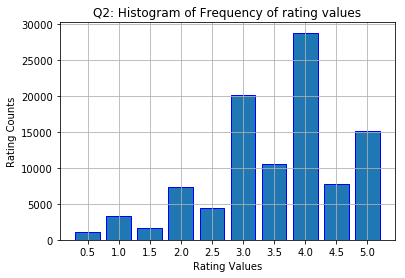

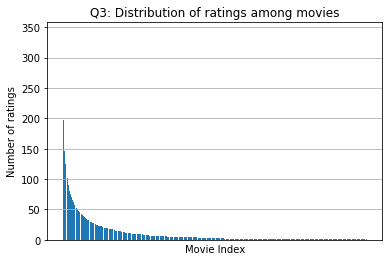

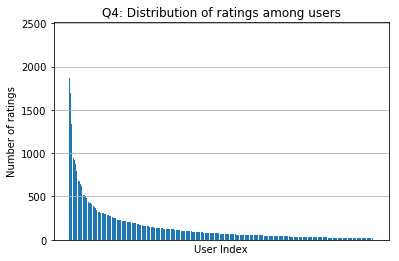

In [28]:
# 1

s1 = S1()
print("Q1: Sparsity = %f" %s1.getSparsity())

hist = Hist(np.arange(0.25,5.5,0.5), "Q2: Histogram of Frequency of rating values",np.arange(0.5,5.5,0.5),"Rating Values", "Rating Counts")
s1.draw(s1.rankings['rating'], hist)

#####

ctr_movieratings = Counter(s1.rankings['movieId'])
bar = Bar("Q3: Distribution of ratings among movies","Movie Index", "Number of ratings")
s1.draw({'X': np.arange(s1.n_items), 'height' : sorted(ctr_movieratings.values(),reverse = True)}, bar)

# Sort user ratings in decreasing order of ratings
ctr_userratings = Counter(s1.rankings['userId'])
bar = Bar("Q4: Distribution of ratings among users","User Index", "Number of ratings")
s1.draw({'X': np.arange(s1.n_users), 'height' : sorted(ctr_userratings.values(),reverse = True)}, bar)




In [29]:
class S2(Solution):
    def getVariance(self):
        ranking_dict = defaultdict(list)
        for i, j in zip(self.rankings.movieId,self.rankings.rating):
            ranking_dict[i].append(j)

    
        ranking_var = list(ranking_dict.values())
        var = []
        for l in ranking_var:
            arr = np.array(l)
            var.append(np.var(l))
        return var

Q6 :Max Variance 5.062500
Q6: Min Variance 0.000000


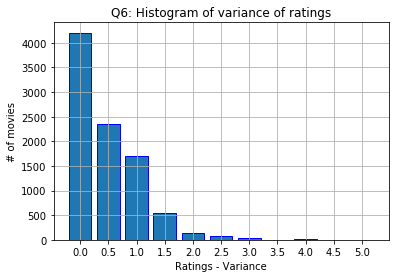

In [30]:
#Q6
s2 = S2()
var = s2.getVariance()
print("Q6 :Max Variance %f"%max(var))
print("Q6: Min Variance %f"%min(var))

hist = Hist(np.arange(min(var)-0.25, max(var)+0.25,0.5), "Q6: Histogram of variance of ratings",
                   np.arange(min(var), max(var)+0.25,0.5),"Ratings - Variance", "# of movies")
s2.draw(var, hist)


In [31]:
s3 = Solution()

In [32]:
s3 = Solution()
algo = KNN(10, 10)
rmse, mae = s3.runAlgo(algo)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

 average RMSE is 0.916716 for k = 54
 average MAE is 0.698727 for k = 54


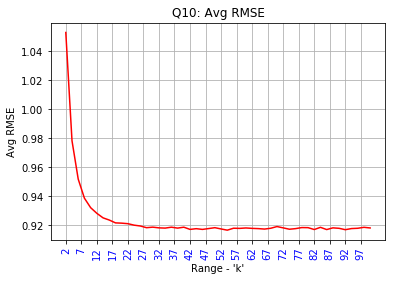

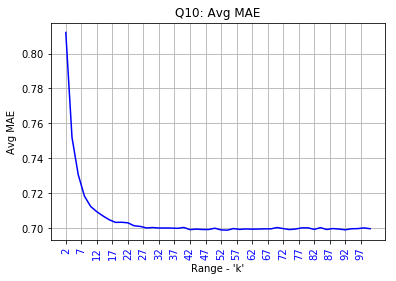

In [35]:
r = range(2, 102, 2)

averageScore(rmse.meas, "RMSE",r)
averageScore(mae.meas, "MAE",r)

rmse_plot = errPlot("Q10: Avg RMSE", "Range - 'k'", "Avg RMSE", np.arange(2,102,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

mae_plot = errPlot("Q10: Avg MAE", "Range - 'k'", "Avg MAE", np.arange(2,102,5))
s3.draw({'r':r,'err':mae.meas, 'color':"blue"},mae_plot)

In [36]:
algo = kFoldKNN(10, 10, popular_set)
rmse = s3.runAlgo(algo)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

 average RMSE is 0.872676 for k = 44


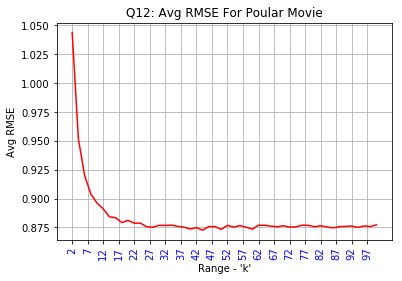

In [37]:
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q12: Avg RMSE For Poular Movie", "Range - 'k'", "Avg RMSE", np.arange(2,102,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [38]:
algo = kFoldKNN(10, 10, unpopular_set)
rmse = s3.runAlgo(algo)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

 average RMSE is 1.004212 for k = 56


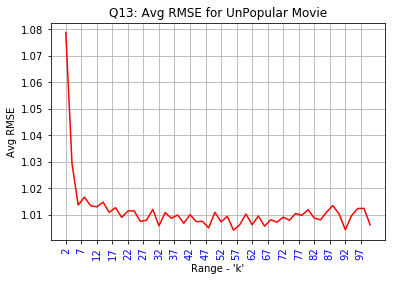

In [39]:
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q13: Avg RMSE for UnPopular Movie", "Range - 'k'", "Avg RMSE", np.arange(2,102,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [40]:
algo = kFoldKNN(10, 10, highvar)
rmse = s3.runAlgo(algo)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

 average RMSE is 1.389821 for k = 28


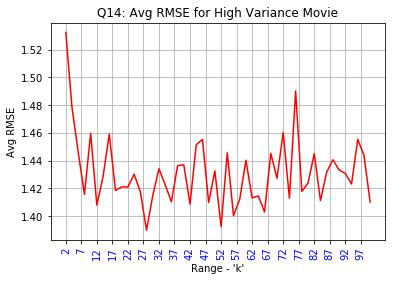

In [41]:
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q14: Avg RMSE for High Variance Movie", "Range - 'k'", "Avg RMSE", np.arange(2,102,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [45]:
algo = KnnWithTrainTestSplit(0.1, 54, [2.5,3,3.5,4])

Computing the pearson similarity matrix...
Done computing similarity matrix.


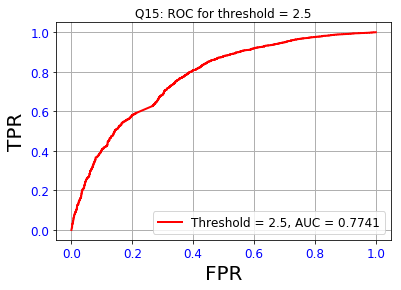

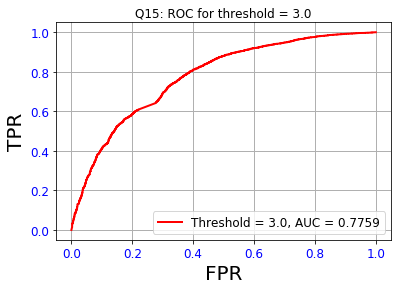

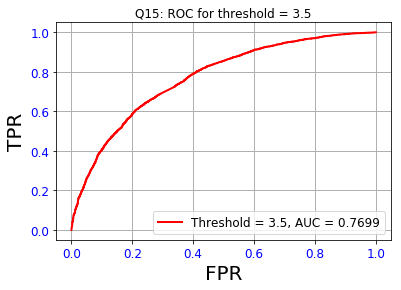

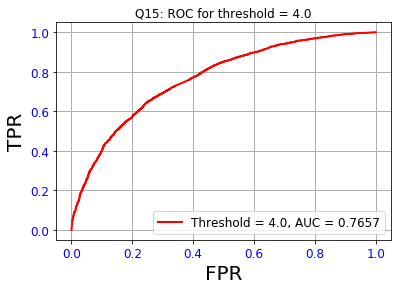

In [46]:
s1.runAlgo(algo)
algo.plotRoc()

### Model-based collaborative filtering

In [47]:
algo = kFoldNMF(10)
rmse, mae = s3.runAlgo(algo)

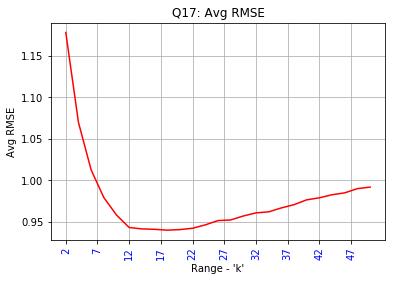

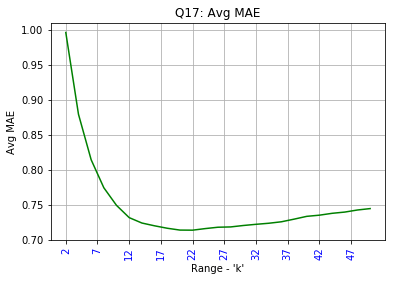

In [48]:
r = range(2, 52, 2)



rmse_plot = errPlot("Q17: Avg RMSE", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

mae_plot = errPlot("Q17: Avg MAE", "Range - 'k'", "Avg MAE", np.arange(2,52,5))
s3.draw({'r':r,'err':mae.meas, 'color':"green"},mae_plot)

In [49]:
print("Q18:")
print("------")
averageScore(rmse.meas, "RMSE",r)
averageScore(mae.meas, "MAE",r)

Q18:
------
 average RMSE is 0.939689 for k = 18
 average MAE is 0.713703 for k = 22


In [50]:
algo = kFoldNMFTrimmed(10, 10, popular_set)
rmse = s3.runAlgo(algo)

Q19:
------
 average RMSE is 0.890900 for k = 16


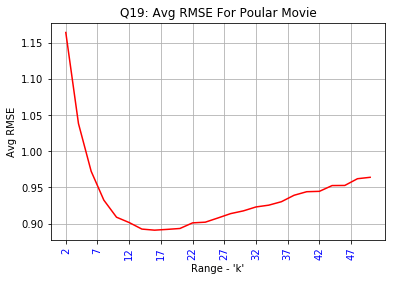

In [51]:
print("Q19:")
print("------")
r = range(2, 52, 2)
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q19: Avg RMSE For Poular Movie", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [55]:
s3 = Solution()
algo = kFoldNMFTrimmed(10, 10, unpopular_set)
rmse = s3.runAlgo(algo)

Q20:
------
 average RMSE is 1.035163 for k = 22


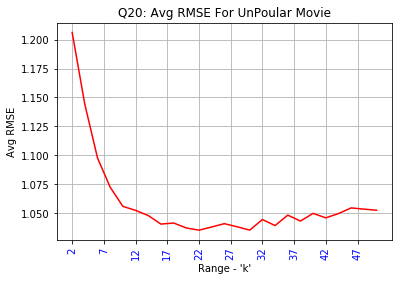

In [56]:
print("Q20:")
print("------")
r = range(2, 52, 2)
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q20: Avg RMSE For UnPoular Movie", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [57]:
algo = kFoldNMFTrimmed(10, 10, highvar)
rmse = s3.runAlgo(algo)

Q21:
------
 average RMSE is 1.403195 for k = 10


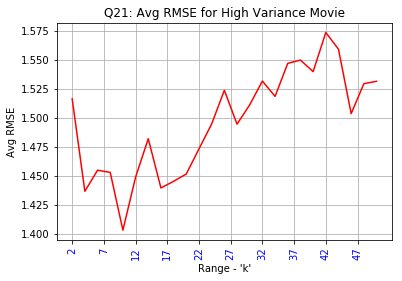

In [58]:
print("Q21:")
print("------")
r = range(2, 52, 2)
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q21: Avg RMSE for High Variance Movie", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [59]:
algo = NMFWithTrainTestSplit(0.1, 18, [2.5,3,3.5,4])
s3.runAlgo(algo)


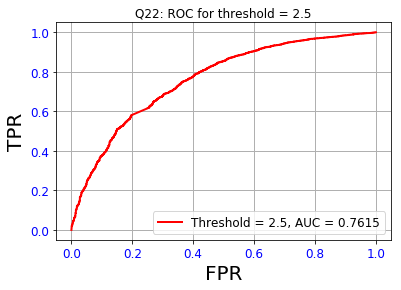

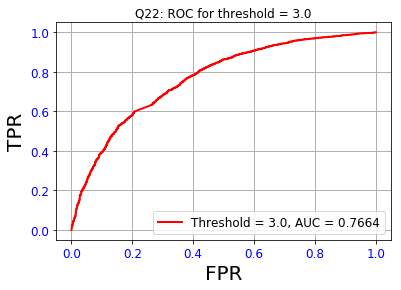

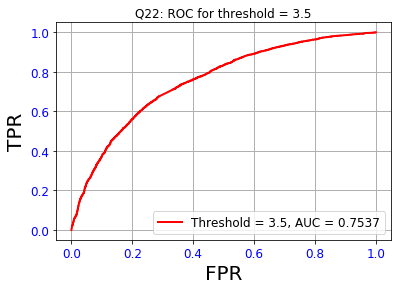

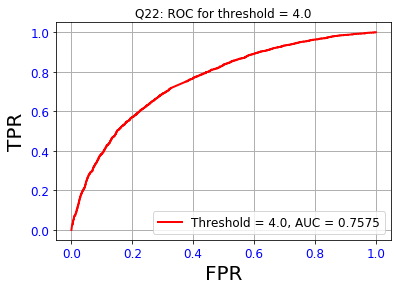

In [60]:
algo.plotRoc()

In [72]:
algo = NMFWithTrainTestSplit(0.1, 20)
s3.runAlgo(algo)

In [73]:
print("Q23:")
print("---------")
algo.getTopMovies()

Q23:
---------

Top Movie -  0
['Drama|Romance', 'Action|Comedy|Fantasy|Musical|Romance', 'Adventure|Romance', 'Adventure|Romance|Western', 'Drama|Sci-Fi', 'Children|Comedy', 'Horror|Sci-Fi', 'Musical|Romance', 'Comedy', 'Adventure|Drama']

Top Movie -  1
['Drama', 'Comedy', 'Comedy|Drama|Musical', 'Western', 'Drama|Romance|War', 'Drama|War', 'Drama|Thriller', 'Romance', 'Drama', 'Action|Comedy|Crime']

Top Movie -  2
['Comedy|Drama|Romance|Sci-Fi', 'Drama|Romance', 'Mystery|Thriller', 'Drama', 'Comedy|Horror', 'Comedy|Drama', 'Action|Crime|Thriller', 'Children|Comedy', 'Comedy|Romance', 'Drama|Horror|Sci-Fi']

Top Movie -  3
['Drama|Western', 'Animation|Children|Comedy|Musical', 'Horror', 'Adventure|Animation|Children|Comedy|IMAX', 'Thriller', 'Drama|Musical|Romance', 'Drama', 'Drama|Fantasy|Horror|Mystery', 'Action|Crime', 'Comedy|Fantasy|Romance']

Top Movie -  4
['Drama|Romance', 'Documentary', 'Thriller', 'Comedy|Musical|Romance', 'Comedy|Crime', 'Crime|Horror|Thriller', 'Drama|Ho

### Matrix factorization with bias (MF with bias)

In [74]:
algo = kFoldSVD(10)
rmse, mae = s3.runAlgo(algo)

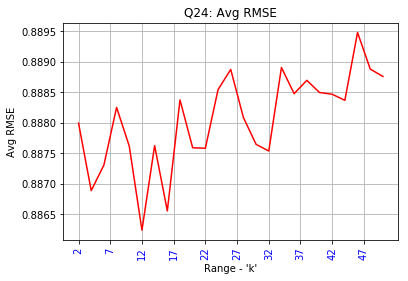

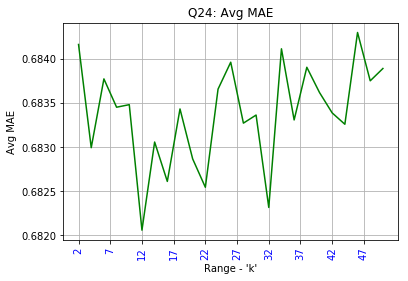

In [75]:
r = range(2, 52, 2)


rmse_plot = errPlot("Q24: Avg RMSE", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

mae_plot = errPlot("Q24: Avg MAE", "Range - 'k'", "Avg MAE", np.arange(2,52,5))
s3.draw({'r':r,'err':mae.meas, 'color':"green"},mae_plot)

In [76]:
print("Q25:")
print("------")
averageScore(rmse.meas, "RMSE",r)
averageScore(mae.meas, "MAE",r)

Q25:
------
 average RMSE is 0.886241 for k = 12
 average MAE is 0.682060 for k = 12


In [77]:
algo = kFoldSVDTrimmed(10, 10, popular_set)
rmse = s3.runAlgo(algo)

Q26:
------
 average RMSE is 0.863830 for k = 36


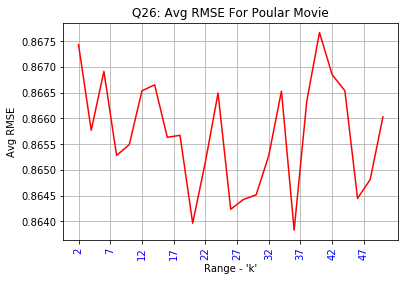

In [78]:
print("Q26:")
print("------")
r = range(2, 52, 2)
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q26: Avg RMSE For Poular Movie", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [79]:
algo = kFoldSVDTrimmed(10, 10, unpopular_set)
rmse = s3.runAlgo(algo)

Q27:
------
 average RMSE is 0.934189 for k = 16


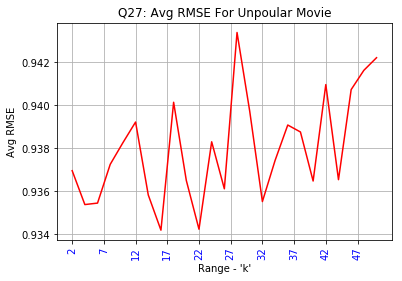

In [80]:
print("Q27:")
print("------")
r = range(2, 52, 2)
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q27: Avg RMSE For Unpoular Movie", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [81]:
algo = kFoldSVDTrimmed(10, 10, highvar)
rmse = s3.runAlgo(algo)

Q28:
------
 average RMSE is 1.400898 for k = 42


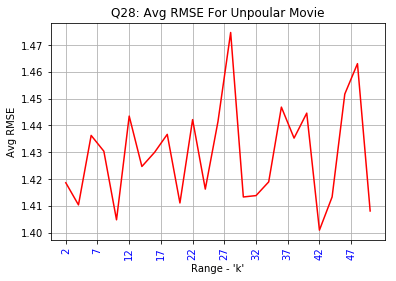

In [82]:
print("Q28:")
print("------")
r = range(2, 52, 2)
averageScore(rmse.meas, "RMSE",r)
rmse_plot = errPlot("Q28: Avg RMSE For Unpoular Movie", "Range - 'k'", "Avg RMSE", np.arange(2,52,5))
s3.draw({'r':r,'err':rmse.meas, 'color':"red"},rmse_plot)

In [83]:
algo = SVDWithTrainTestSplit(0.1, 12, [2.5,3,3.5,4])
s3.runAlgo(algo)

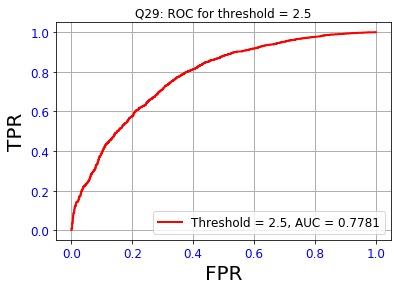

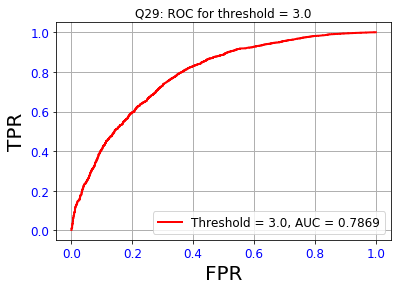

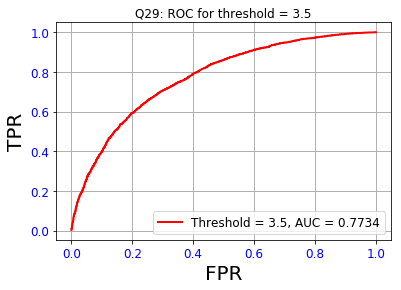

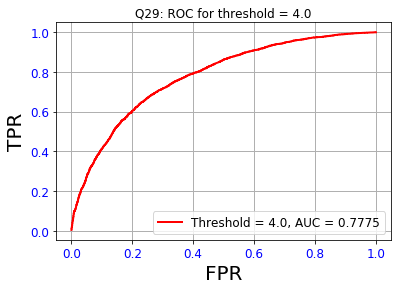

In [84]:
algo.plotRoc()

In [85]:
algo = kFoldNF(10)
rmse = s3.runAlgo(algo)

print("Q:30 :")
print("--------")
print("Avg RMSE with 10 fold cross val and using Naive collab filter is %0.4f" % rmse)
            

Q:30 :
--------
Avg RMSE with 10 fold cross val and using Naive collab filter is 0.9129


In [86]:
algo = kFoldNF(10,popular_set)
rmse = s3.runAlgo(algo)

print("Q:31 :")
print("--------")
print("Avg RMSE with 10 fold cross val and using Naive collab filter over Popular set is %0.4f" % rmse)

Q:31 :
--------
Avg RMSE with 10 fold cross val and using Naive collab filter over Popular set is 0.8852


In [87]:
algo = kFoldNF(10,unpopular_set)
rmse = s3.runAlgo(algo)

print("Q:32 :")
print("--------")
print("Avg RMSE with 10 fold cross val and using Naive collab filter over Un-Popular set is %0.4f" % rmse)

Q:32 :
--------
Avg RMSE with 10 fold cross val and using Naive collab filter over Un-Popular set is 0.9848


In [88]:
algo = kFoldNF(10,highvar)
rmse = s3.runAlgo(algo)

print("Q:33 :")
print("--------")
print("Avg RMSE with 10 fold cross val and using Naive collab filter over High Variance set is %0.4f" % rmse)

Q:33 :
--------
Avg RMSE with 10 fold cross val and using Naive collab filter over High Variance set is 2.1222


In [89]:
knn = KnnWithTrainTestSplit(0.1, 24, [3])
s3.runAlgo(knn)

Computing the pearson similarity matrix...
Done computing similarity matrix.
